In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/gene-expression-omnibus-geo-dataset-gse68086/GSE68086_TEP_data_matrix.csv
/kaggle/input/gene-expression-omnibus-geo-dataset-gse68086/GSE68086_series_matrix.txt
/kaggle/input/gene-expression-omnibus-geo-dataset-gse68086/GSE68086_series_matrix.csv
/kaggle/input/gene-expression-omnibus-geo-dataset-gse68086/GSE68086_TEP_data_matrix.txt/GSE68086_TEP_data_matrix.txt


In [2]:
#load data
expr = pd.read_csv('/kaggle/input/gene-expression-omnibus-geo-dataset-gse68086/GSE68086_TEP_data_matrix.csv')
meta = pd.read_csv('/kaggle/input/gene-expression-omnibus-geo-dataset-gse68086/GSE68086_series_matrix.csv')

In [3]:
#learn data
print(expr.shape)
print(meta.shape)
print(expr.head())
print(meta.head())

expr.columns[1:6]
meta['!Sample_source_name_ch1'].head()

print(meta['!Sample_source_name_ch1'].unique())
print(meta['!Sample_characteristics_ch1.1'].unique())
print(meta['!Sample_characteristics_ch1.1'].value_counts())

(57736, 286)
(285, 46)
        Unnamed: 0  3-Breast-Her2-ampl  8-Breast-WT  10-Breast-Her2-ampl  \
0  ENSG00000000003                   0            0                    0   
1  ENSG00000000005                   0            0                    0   
2  ENSG00000000419                  44           14                   16   
3  ENSG00000000457                  26            1                   14   
4  ENSG00000000460                  81           98                   18   

   Breast-100  15-Breast-Her2-ampl  16-Breast-WT  21-Breast-WT  \
0           0                   17             0             0   
1           0                    0             0             0   
2           8                    9             0           139   
3           0                    4            20             1   
4          17                    0            20           144   

   33-Breast-Her2-ampl  42-Breast-Her2-ampl  ...  MGH-NSCLC-L20-TR500  \
0                    0                    0  ...  

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


In [4]:
#create cancer/healthy label
meta['sample_name'] = meta['!Sample_source_name_ch1'].str.strip('"')
#meta['label_cancer'] = -meta['sample_name'].str.startswith(('HD-', 'Control-'))
#meta['label_cancer'].value_counts()

def classify_sample(name):
    if name.startswith('HD-') or name.startswith('Control-'):
        return 'Healthy'
    elif name.startswith('Type-Unknown-'):
        return 'Type-Unknown'
    else:
        return 'Cancer'

meta['disease_status'] = meta['sample_name'].apply(classify_sample)
meta['disease_status'].value_counts()

disease_status
Cancer          226
Healthy          54
Type-Unknown      5
Name: count, dtype: int64

In [5]:
#delete 'Type-Unknown' samples
meta_clean = meta[meta['disease_status'] != 'Type-Unknown']
meta_clean['disease_status'].value_counts()

disease_status
Cancer     226
Healthy     54
Name: count, dtype: int64

In [6]:
#check if aligned
expr_samples = set(expr.columns[1:])
meta_samples = set(meta_clean['sample_name'])

common_samples = expr_samples & meta_samples
len(common_samples)

280

In [7]:
expr_clean = expr[['Unnamed: 0'] + list(common_samples)]
meta_clean = meta_clean[meta_clean['sample_name'].isin(common_samples)]

print(expr_clean.shape)
print(meta_clean.shape)
print(meta_clean.head())
print(meta_clean['disease_status'].value_counts())

set(expr_clean.columns[1:]) == set(meta_clean['sample_name'])

(57736, 281)
(280, 48)
  !Sample_geo_accession           !Sample_status !Sample_submission_date  \
0          "GSM1662534"  "Public on Oct 30 2015"           "Apr 21 2015"   
1          "GSM1662535"  "Public on Oct 30 2015"           "Apr 21 2015"   
2          "GSM1662536"  "Public on Oct 30 2015"           "Apr 21 2015"   
3          "GSM1662537"  "Public on Oct 30 2015"           "Apr 21 2015"   
4          "GSM1662538"  "Public on Oct 30 2015"           "Apr 21 2015"   

  !Sample_last_update_date !Sample_type !Sample_channel_count  \
0            "May 15 2019"        "SRA"                   "1"   
1            "May 15 2019"        "SRA"                   "1"   
2            "May 15 2019"        "SRA"                   "1"   
3            "May 15 2019"        "SRA"                   "1"   
4            "May 15 2019"        "SRA"                   "1"   

  !Sample_source_name_ch1 !Sample_organism_ch1 !Sample_characteristics_ch1  \
0    "3-Breast-Her2-ampl"       "Homo sapiens"     

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


True

In [8]:
#1 solution1 
#以表达矩阵的样本顺序为主，用meta进行索引对齐，确保XY一致
X = expr_clean.iloc[:, 1:].T
Y = meta_clean.set_index('sample_name').loc[X.index, 'disease_status']
print(X.shape)
print(Y.shape)
print(X.head())
print(Y.head())

(280, 57736)
(280,)
                    0      1      2      3      4      5      6      7      \
MGH-BrCa-H92-TR472      0      0      4      0     36     70      0     37   
286-Pancr-286-WT        0      0     60     17     22    224     29     46   
HD-7                    0      0     42      2     14    150     22     99   
Panc-503                0      0      0      2      8     16      3     10   
504-CRC-WT              1      0     31      6     43     32      0     58   

                    8      9      ...  57726  57727  57728  57729  57730  \
MGH-BrCa-H92-TR472      0      3  ...      0      0      0      0      0   
286-Pancr-286-WT       14     14  ...      0      0      0      0      0   
HD-7                    7      0  ...      0      0      0      0      0   
Panc-503                0      7  ...      0      0      0      0      0   
504-CRC-WT              0      5  ...      0      0      0      0      0   

                    57731  57732  57733  57734  57735 

In [9]:
#2 solution2 convenient but risky 
#快捷但风险高，假设所有meta里的sample都在expr里且顺序不会错
#x = expr_clean[meta_clean['sample_name']]
#y = meta_clean['disease_status']
#print(x.shape)
#print(y.shape)
#print(x.head())
#print(y.head())

In [10]:
#filter for computing speed 筛选基因，避免直接标准化计算量过大系统卡死
gene_var = X.var(axis=0)  #或者gene_var = x.var(axis=1)，axis指向sample维度，这段后续都是x
top_genes = gene_var.sort_values(ascending=False).head(1000).index #这里选1000是因为经验上说n_features ≤ 3–5 × n_samples，过大容易过拟合
X_top = X[top_genes]
print(X_top.shape)

(280, 1000)


In [11]:
#standard
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_top)

In [12]:
#PCA（只取前两个主成分）
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print(X_pca.shape)

pca_df = pd.DataFrame(
    X_pca,
    columns=['pc1', 'pc2'],
    index=X.index
)
pca_df['disease_status'] = Y.values

print(pca_df.head())

(280, 2)
                          pc1        pc2 disease_status
MGH-BrCa-H92-TR472   8.998108 -20.821332         Cancer
286-Pancr-286-WT    28.157135  17.247174         Cancer
HD-7                -8.472149  13.310219        Healthy
Panc-503           -15.889582  -2.717402         Cancer
504-CRC-WT          16.443094  -2.905031         Cancer


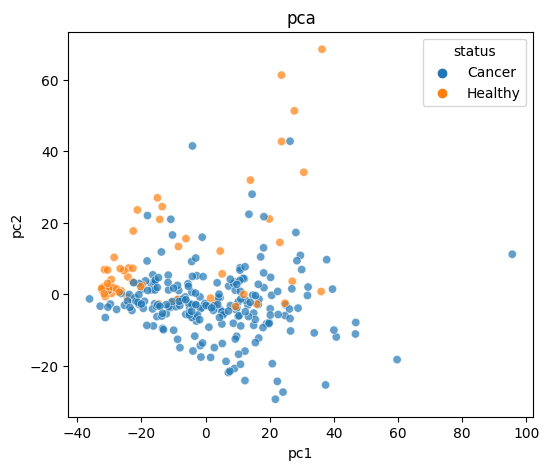

In [13]:
#draw
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,5))
sns.scatterplot(
    data=pca_df, 
    x='pc1', 
    y='pc2', 
    hue='disease_status',
    alpha=0.7
)
plt.title('pca')
plt.xlabel('pc1')
plt.ylabel('pc2')
plt.legend(title='status')
plt.show()

In [14]:
#create train set and test set
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegression

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, 
    test_size=0.2, 
    random_state=42,
    stratify=Y  #分数据的时候，按照 y 的类别比例来分，保证训练集和测试集里的cancer/healthy比例一致
)

scaler.fit(X_train) #只在训练集学规则，训练集决定世界观，transform是用学好的规则去变换数据
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [15]:
#train
logistic_reg = LogisticRegression(
    penalty='l2', #防止模型乱拟合
    C=1.0,   #正则化强度，先用默认
    solver='liblinear',
    max_iter=1000,  #防止不收敛
    random_state=42
)

logistic_reg.fit(X_train_scaled, Y_train)

LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')

In [16]:
#predict
Y_predict = logistic_reg.predict(X_test_scaled)
Y_prob = logistic_reg.predict_proba(X_test_scaled)[:, 1]

acc = accuracy_score(Y_test, Y_predict)
auc = roc_auc_score(Y_test, Y_prob)

print("accuracy:", acc)
print("roc_auc:", auc)
print(classification_report(Y_test, Y_predict))

accuracy: 0.8571428571428571
roc_auc: 0.9212121212121211
              precision    recall  f1-score   support

      Cancer       0.97      0.84      0.90        45
     Healthy       0.59      0.91      0.71        11

    accuracy                           0.86        56
   macro avg       0.78      0.88      0.81        56
weighted avg       0.90      0.86      0.87        56

